# Simple CNN for MNIST

## Imports:  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, TensorBoard

import tensorflow as tf
import os
import time
import pickle

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


#### Working directory:

In [2]:
working_dir="C:/Users/chenx/Desktop/1811_softdesign/20181125 - MNIST/"

## Data

In [3]:
train_csv_path = os.path.join(working_dir, "train.csv")
test_csv_path = os.path.join(working_dir, "test.csv")

train = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)

#### Separate training data into X,Y:  
X: Training Label  
Y: Image Data

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

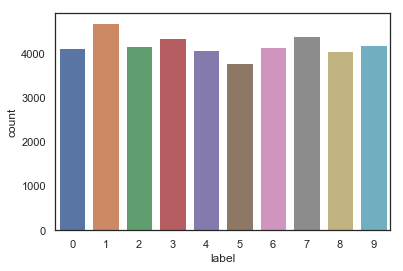

In [4]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

# Visualization:
g = sns.countplot(Y_train)
Y_train.value_counts()

#### Checking for nulls:

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

#### Normalization:
  
From grayscale 0~255 to 0~1  
  

In [7]:
X_train = X_train / 255.0
test = test / 255.0

#### Reshaping:
From 1D 784 to 28x28x1

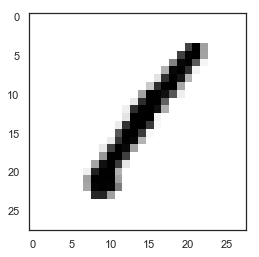

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

g = plt.imshow(X_train[0][:,:,0], cmap=plt.cm.binary)

#### Y_train label to hot vector

In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)

Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

#### Splitting test data

In [10]:
random_seed = 0

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train,
                                                  test_size=0.1, # 10% used for validation
                                                  random_state=random_seed)

#### Saving processed data
    Using pickle to save processed data

In [11]:
pfile = open(os.path.join("X_train.pickle"), "wb")
pickle.dump(X_train, pfile)
pfile.close()

pfile = open(os.path.join("X_test.pickle"), "wb")
pickle.dump(X_test, pfile)
pfile.close()

pfile = open(os.path.join("Y_train.pickle"), "wb")
pickle.dump(Y_train, pfile)
pfile.close()

pfile = open(os.path.join("Y_test.pickle"), "wb")
pickle.dump(Y_test, pfile)
pfile.close()

In [40]:
pfile = open(os.path.join("X_train.pickle"), "rb")
X_train = pickle.load(pfile)
pfile.close()

pfile = open(os.path.join("X_test.pickle"), "rb")
X_test = pickle.load(pfile)
pfile.close()

pfile = open(os.path.join("Y_train.pickle"), "rb")
Y_train = pickle.load(pfile)
pfile.close()

pfile = open(os.path.join("Y_test.pickle"), "rb")
Y_test = pickle.load(pfile)
pfile.close()

## Models
+ Simple
+ Convoluted

### Super simple model
     Input Layer
     All connected, size 128
     All connected, size 128
     Output all connected, size 10

In [34]:
simple_model = Sequential()

simple_model.add(Flatten())
simple_model.add(Dense(128, activation="relu"))
simple_model.add(Dense(128, activation="relu"))
simple_model.add(Dense(10, activation="softmax"))

#### Training
    Using "adam" as optimizer: this is an ordinary optimizer for NNs
    "categorical_crossentropy" as loss function: this is also ordinary
    Epoch: 5, not a very complicated network

In [35]:
simple_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [37]:
simple_model.fit(X_train, Y_train, 
                 epochs=30,
                validation_data = (X_test,Y_test))

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 5s 128us/step - loss: 0.0331 - acc: 0.9892 - val_loss: 0.1288 - val_acc: 0.9671
Epoch 2/30
37800/37800 [==============================] - 5s 120us/step - loss: 0.0270 - acc: 0.9908 - val_loss: 0.1228 - val_acc: 0.9681
Epoch 3/30
37800/37800 [==============================] - 4s 118us/step - loss: 0.0248 - acc: 0.9918 - val_loss: 0.1349 - val_acc: 0.9679
Epoch 4/30
37800/37800 [==============================] - 4s 119us/step - loss: 0.0198 - acc: 0.9935 - val_loss: 0.1520 - val_acc: 0.9662
Epoch 5/30
37800/37800 [==============================] - 5s 120us/step - loss: 0.0201 - acc: 0.9934 - val_loss: 0.1265 - val_acc: 0.9710
Epoch 6/30
37800/37800 [==============================] - 4s 119us/step - loss: 0.0136 - acc: 0.9953 - val_loss: 0.1480 - val_acc: 0.9695
Epoch 7/30
37800/37800 [==============================] - 5s 124us/step - loss: 0.0204 - acc: 0.9934 - val_loss: 0.1460 - v

#### Evaluation
     Loss and accuracy is slightly lower than in training:
     Not very overfitted

In [38]:
val_loss, val_acc = simple_model.evaluate(X_test, Y_test)
print(val_loss, val_acc)

4200/4200 [==============================] - 0s 58us/step
0.18869466008650318 0.9757142857142858


#### Looking at a random example

In [17]:
predictions = simple_model.predict([X_test])

1


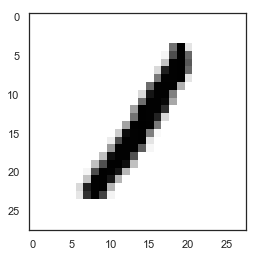

In [18]:
choice = np.random.randint(0,4201)

print(np.argmax(predictions[choice]))
g = plt.imshow(X_test[choice][:,:,0], cmap=plt.cm.binary)

#### Saving simple_model

In [39]:
simple_model_name = "mnist-simple-{}.model".format(int(time.time()))
simple_model.save(os.path.join(simple_model_name))

### CNN Model:
    Convlution size32 x2
    Down Sampling by 2x2
    Drop Out by 25% probablity
    
    Convlution size64 x2
    Down Sampling by 2x2
    Drop Out by 25% probablity
    
    Flatten layer
    All connected size256
    Drop Out by 50% probablity
    Output all connected size10

In [50]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters = 32,
                    kernel_size = (5,5),
                    padding = 'Same',
                    activation = 'relu',
                    input_shape = (28,28,1)))

cnn_model.add(Conv2D(filters = 32,
                    kernel_size = (5,5),
                    padding = 'Same',
                    activation = 'relu',
                    input_shape = (28,28,1)))

cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Conv2D(filters = 64,
                    kernel_size = (3, 3),
                    padding = 'Same',
                    activation = 'relu',
                    input_shape = (28,28,1)))

cnn_model.add(Conv2D(filters = 64,
                    kernel_size = (3, 3),
                    padding = 'Same',
                    activation = 'relu',
                    input_shape = (28,28,1)))

cnn_model.add(MaxPool2D(pool_size=(2, 2),
                        strides=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(10, activation='softmax')) # Output Layer

#### Optimizer and loss function
* Optimizer:
      "Adam", because it is easier to type
* Loss Function:
      categorical_crossentropy as ordinary loss function

In [51]:
cnn_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
hasattr(cnn_model, 'train_function')

True

#### Learning rate reduction

In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#### Data augmentation
    Randomly shift, zoom ,rotate; manipulate the images to minimize overfitting

In [53]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

#### Training

In [54]:
epochs = 16
batch_size = 32

In [55]:
#Setting up TensorBoard:
cnn_model_name = "mnist-cnn-e%i-b%i-%i" %(epochs, batch_size,int(time.time()))
logd = os.path.join(working_dir, "logs", cnn_model_name)
tensorboard = TensorBoard(log_dir=logd)

In [56]:
history = cnn_model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),
                                  epochs = epochs, 
                                  validation_data = (X_test,Y_test), 
                                  steps_per_epoch = X_train.shape[0] // batch_size, 
                                  callbacks = [learning_rate_reduction, tensorboard])

Epoch 1/16
1181/1181 [==============================] - 12s 10ms/step - loss: 0.3436 - acc: 0.8912 - val_loss: 0.0631 - val_acc: 0.9821
Epoch 2/16
1181/1181 [==============================] - 12s 10ms/step - loss: 0.1224 - acc: 0.9639 - val_loss: 0.0399 - val_acc: 0.9879
Epoch 3/16
1181/1181 [==============================] - 11s 10ms/step - loss: 0.0903 - acc: 0.9735 - val_loss: 0.0442 - val_acc: 0.9881
Epoch 4/16
1181/1181 [==============================] - 11s 10ms/step - loss: 0.0792 - acc: 0.9762 - val_loss: 0.0593 - val_acc: 0.9824
Epoch 5/16
1181/1181 [==============================] - 11s 10ms/step - loss: 0.0700 - acc: 0.9790 - val_loss: 0.0429 - val_acc: 0.9888
Epoch 6/16
1181/1181 [==============================] - 11s 10ms/step - loss: 0.0642 - acc: 0.9815 - val_loss: 0.0322 - val_acc: 0.9912
Epoch 7/16
1181/1181 [==============================] - 11s 10ms/step - loss: 0.0619 - acc: 0.9820 - val_loss: 0.0250 - val_acc: 0.9907
Epoch 8/16
1181/1181 [==========================

In [57]:
val_loss, val_acc = cnn_model.evaluate(X_test, Y_test)
print(val_loss, val_acc)

4200/4200 [==============================] - 0s 105us/step
0.018718373173953643 0.9945238095238095


In [58]:
cnn_model.save(os.path.join(cnn_model_name)+".model")